# 📥 Step 1: Import Libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

import warnings
warnings.filterwarnings('ignore')

# 📋 Step 2: Data Understanding 

In [2]:
df = pd.read_csv('StoreDemand.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
df.shape

(913000, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [6]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

# 🔧 Step 3: Feature Engineering

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df['year']=df['date'].dt.year
df['month']=df['date'].dt.month
df['day']=df['date'].dt.day
df['weekday'] = df['date'].dt.dayofweek
df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


In [9]:
#Whether it is a weekend or a weekday must have some effect on the requirements to fulfill the demands

from datetime import datetime

def weekend_or_weekday(year, month, day):
    d = datetime(year, month, day)
    return 1 if d.weekday() > 4 else 0

df['weekend'] = df.apply(lambda x: weekend_or_weekday(x['year'], x['month'], x['day']), axis=1)
df.head()

,date,store,item,sales,year,month,day,weekday,weekend
0,2013-01-01,1,1,13,2013,1,1,1,0
1,2013-01-02,1,1,11,2013,1,2,2,0
2,2013-01-03,1,1,14,2013,1,3,3,0
3,2013-01-04,1,1,13,2013,1,4,4,0
4,2013-01-05,1,1,10,2013,1,5,5,1


In [10]:
#indicate whether there was any holiday on a particular day or not.
from datetime import date
import holidays

india_holidays = holidays.country_holidays('IN')
df['holidays'] = df['date'].apply(lambda x: 1 if india_holidays.get(x) else 0)
df.head()

,date,store,item,sales,year,month,day,weekday,weekend,holidays
0,2013-01-01,1,1,13,2013,1,1,1,0,0
1,2013-01-02,1,1,11,2013,1,2,2,0,0
2,2013-01-03,1,1,14,2013,1,3,3,0,0
3,2013-01-04,1,1,13,2013,1,4,4,0,0
4,2013-01-05,1,1,10,2013,1,5,5,1,0


### Adding some cyclic features

In [11]:
df['m1'] = np.sin(df['month'] * (2 * np.pi / 12))
df['m2'] = np.cos(df['month'] * (2 * np.pi / 12))
df['m3'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['m4'] = np.cos(2 * np.pi * df['weekday'] / 7)
df.head()

,date,store,item,sales,year,month,day,weekday,weekend,holidays,m1,m2,m3,m4
0,2013-01-01,1,1,13,2013,1,1,1,0,0,0.5,0.866025,0.781831,0.623490
1,2013-01-02,1,1,11,2013,1,2,2,0,0,0.5,0.866025,0.974928,-0.222521
2,2013-01-03,1,1,14,2013,1,3,3,0,0,0.5,0.866025,0.433884,-0.900969
3,2013-01-04,1,1,13,2013,1,4,4,0,0,0.5,0.866025,-0.433884,-0.900969
4,2013-01-05,1,1,10,2013,1,5,5,1,0,0.5,0.866025,-0.974928,-0.222521


In [12]:
#Remove date colm
df.drop('date', axis=1, inplace=True)   # as we have already taken out day,month,and year

# Step 4 **Exploratory Data Analysis**


In [13]:
#check the unique values in the store and item column using nunique().
df['store'].nunique(), df['item'].nunique()    # there are 10 unique stores and they sell 50 different products

(10, 50)

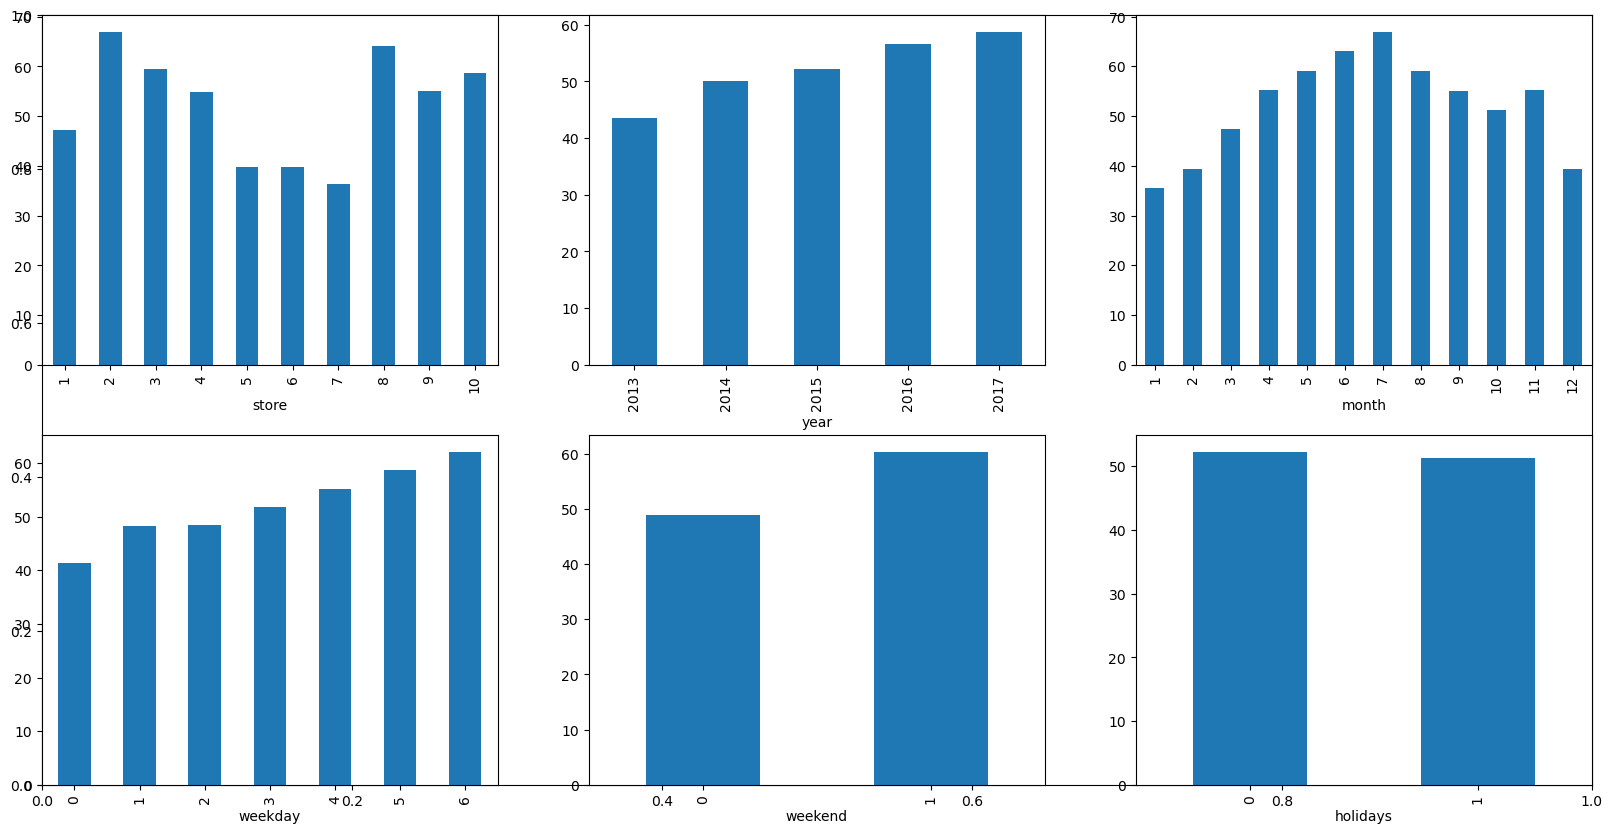

In [14]:
#analyze the relationship between various features and sales performance by visualizing

df['weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)
features = ['store', 'year', 'month', 'weekday', 'weekend', 'holidays']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    df.groupby(col).mean()['sales'].plot.bar()
plt.show()

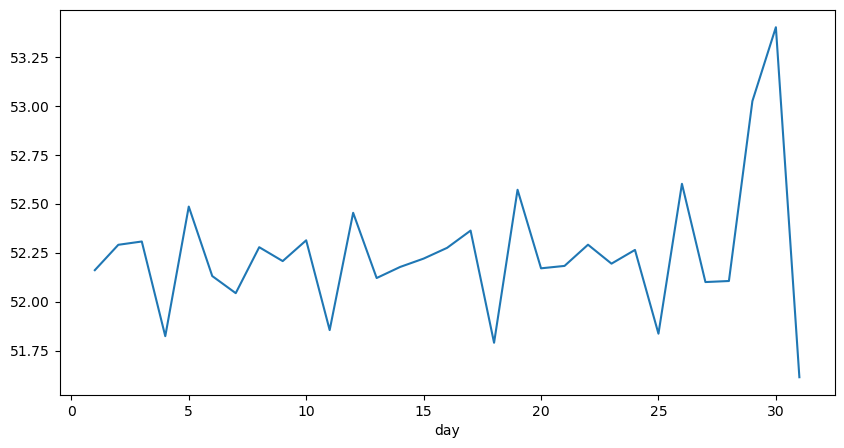

In [15]:
#variation of stock as the month closes to the end using line plot.
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()

### Plotting simple moving average with help to smooth out short-term fluctuations and highlight longer-term trend or cycles in the data:

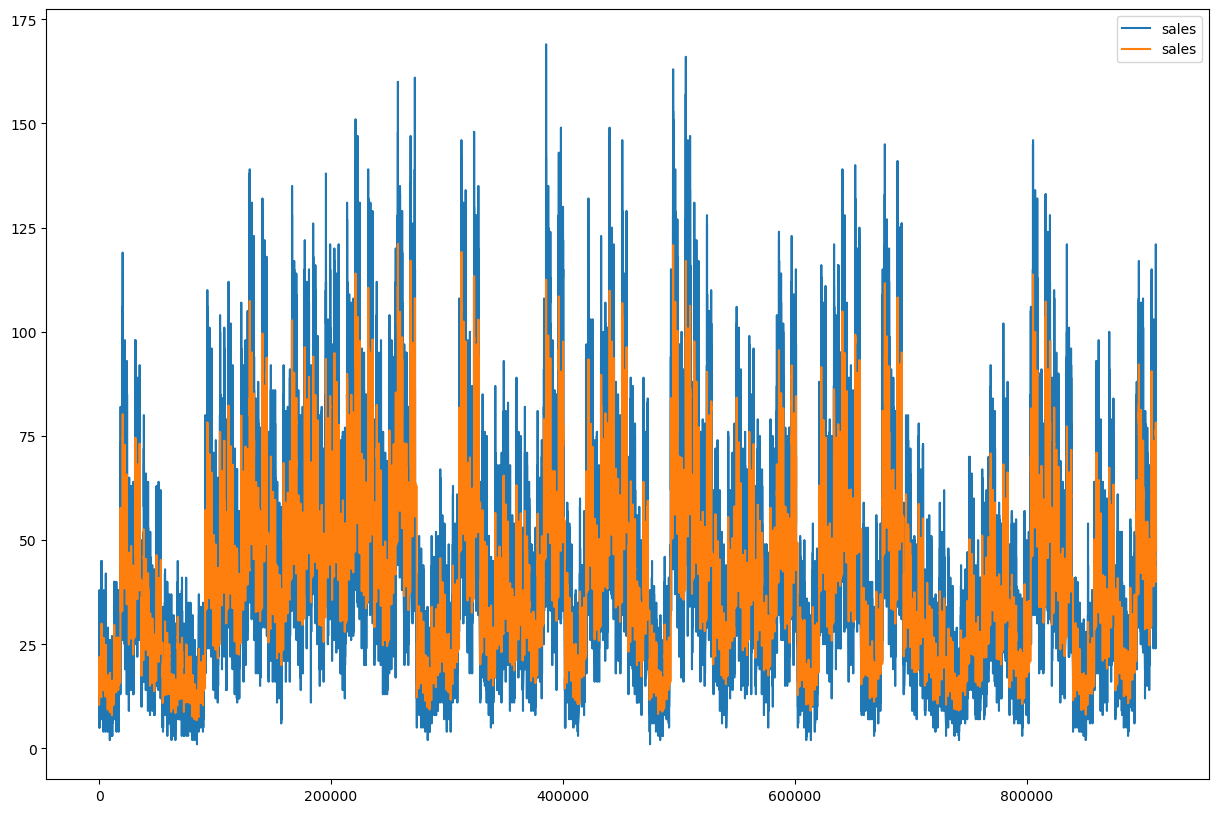

In [16]:
plt.figure(figsize=(15, 10))

# Calculating Simple Moving Average 
# for a window period of 30 days
window_size = 30
data = df[df['year']==2013]
windows = data['sales'].rolling(window_size)
sma = windows.mean()
sma = sma[window_size - 1:]

data['sales'].plot()
sma.plot()
plt.legend()
plt.show()

### As the data in the sales column is continuous let's check the distribution of it and check whether there are some outliers in this column or not. For this we are using distplot and boxplot.

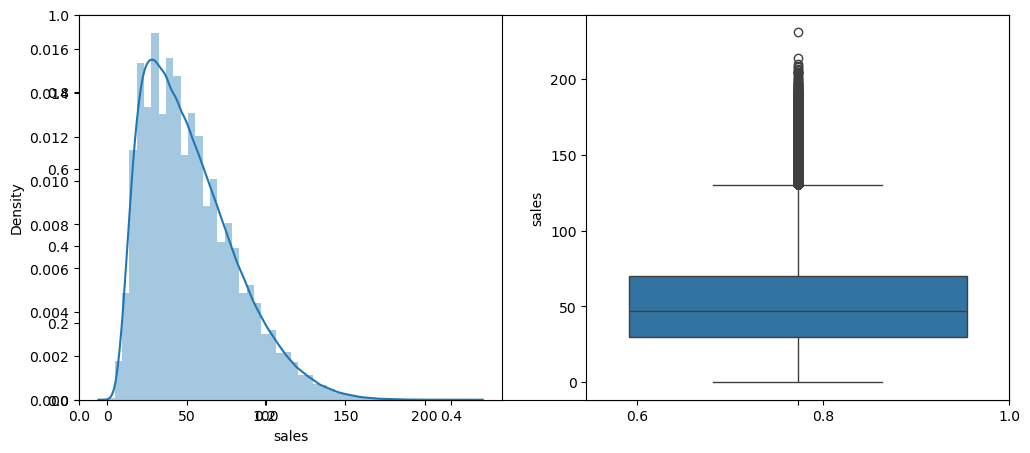

In [17]:
plt.subplots(figsize=(12, 5))
plt.subplot(1, 2, 1)
sb.distplot(df['sales'])

plt.subplot(1, 2, 2)
sb.boxplot(df['sales'])
plt.show()

### check the correlation between the features of the data and added a filter to identify only the highly correlated features. For computing the correlation between the features of the dataset, we use corr() function:

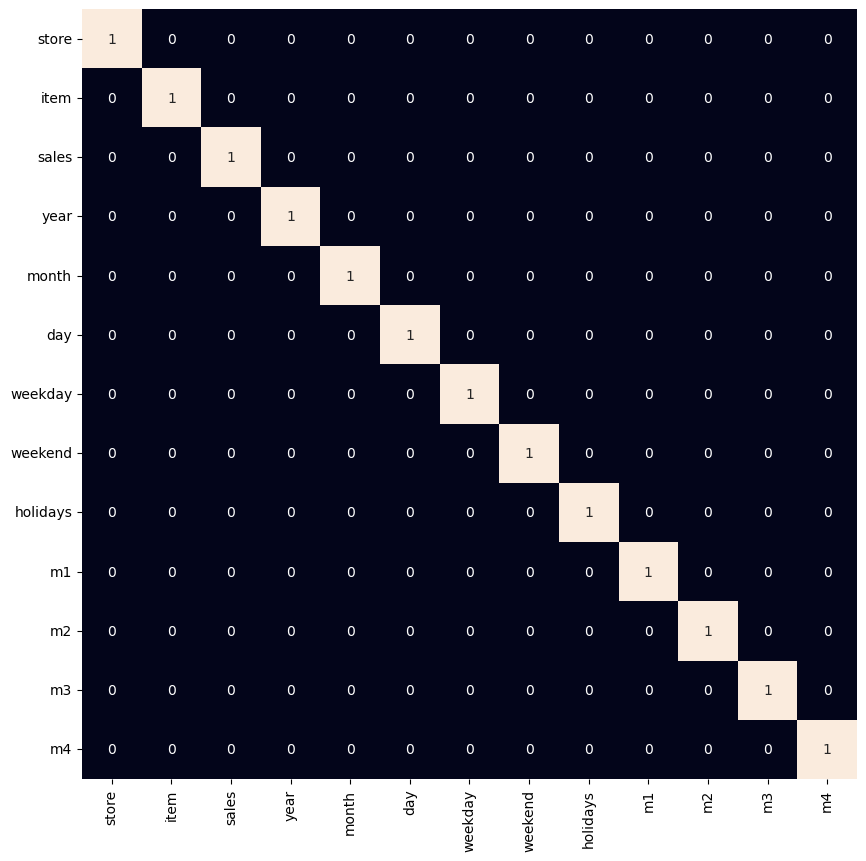

In [18]:
plt.figure(figsize=(10, 10))
sb.heatmap(df.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

### As we observed earlier let's remove the outliers which are present in the data

In [19]:
df = df[df['sales']<140]

# Step 5 📊 Data Split using Train-Test Split


In [20]:
features = df.drop(['sales', 'year'], axis=1)
target = df['sales'].values


X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                                  test_size = 0.05,
                                                  random_state=22)
X_train.shape, X_val.shape

((861170, 11), (45325, 11))

### Normalizing the data before feeding it into machine learning models helps us to achieve stable and fast training:

In [21]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

#  Step 6 🤖 Model Training and 📈 Evaluating Model Performance

In [22]:
models = [LinearRegression(), XGBRegressor(), Lasso(), Ridge()]

for i in range(4):
    models[i].fit(X_train, Y_train)

    print(f'{models[i]} : ')

    train_preds = models[i].predict(X_train)
    print('Training Error : ', mae(Y_train, train_preds))

    val_preds = models[i].predict(X_val)
    print('Validation Error : ', mae(Y_val, val_preds))
    print()

LinearRegression() : 
Training Error :  20.89946491342273
Validation Error :  20.967520180122932

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...) : 
Training Error :  6.906708525772045
Validation Error :  6.916450167838474

Lasso() : 
Training Error :  21.015032497834554
Validation Error :  21.071

# 📊 Model Training Results & Insights

## 🔹 Performance Summary

| Model | Training Error | Validation Error |
|:------|----------------:|-----------------:|
| **Linear Regression** | 20.90 | 20.97 |
| **XGBoost Regressor** | **6.91** | **6.92** |
| **Lasso Regression** | 21.02 | 21.07 |
| **Ridge Regression** | 20.90 | 20.97 |

---

## 🔹 Key Inferences

1. **XGBoost clearly outperforms linear models**  
   - Training Error (6.91) and Validation Error (6.92) are significantly lower.  
   - It captures complex non-linear patterns that linear models cannot.

2. **Linear, Ridge, and Lasso perform similarly**  
   - Their errors (~21) indicate limited ability to capture non-linear relationships.  

3. **No overfitting observed in XGBoost**  
   - Training and validation errors are nearly equal (6.91 vs 6.92).  
   - Suggests stable generalization performance.

4. **Regularization had minimal effect**  
   - Lasso and Ridge did not improve accuracy over plain Linear Regression.  
   - Indicates low multicollinearity and stable linear relationships.

---

## 🔹 Insights & Next Steps

- ✅ **Best Model:** `XGBoostRegressor` — best overall performance and generalization.  
- 🔍 **Interpretability vs Accuracy:**  
  - Linear models are simpler but less accurate.  
  - XGBoost is more accurate but needs feature importance analysis for interpretation.  
- ⚙️ **Future Improvements:**  
  - Tune XGBoost hyperparameters (`max_depth`, `learning_rate`, `n_estimators`, etc.).  
  - Add lag features or rolling statistics to enhance temporal understanding.  
  - Apply cross-validation for more reliable performance metrics.

---

✅ **Conclusion:**  
`XGBoostRegressor` is the most effective model for this inventory demand forecasting task.  
It captures complex seasonality and non-linear relationships while maintaining excellent generalization.
